In [1]:
# This script will import data from the LocalAir Escooter-based sensors.
# Data is encryped by the sensors, and this script decryptes before converting it into a pandas dataframe
# and then visualising it.
# Data can either be retrieved from a speificied folder, where all of the .bin files will be imported,
# or it can be downloaded directly from the website which the sensors uploads to. To avoid downloading
# files unnecceraily a time range can be specified.
# Behaviour is controlled through the "source" flag.

# importing the relevent libaries
from speck import SpeckCipher
import sys
import os

import geopandas as gpd
import pandas as pd
from shapely.geometry import LineString
import json

import pytz
from datetime import datetime

import urllib.request, urllib.error, urllib.parse

import numpy as np

import matplotlib.pyplot as plt

import random

# some variables to control behvaiousr
pd.options.display.max_columns = None
# 'uploadFormat' is uesed to specify iif the file has come via being uplaoded, or if it is direct from
# the SD card. Something happens during the upload process that introduces a lot of new line charactors,
# and the software must get rid of these before it can process the file.
uploadFormat = False
numOfChunks = 60
source = 'Folder' # can be 'Download' for downloading direclty of the web, 
                    # or 'Folder' for reading from a folder

# If you are working with files in a folder then this is the name of the directory where the files are stored
# if you have downloaded this off git you will need to change this!
directory_in_str = '/home/lifegarb/Documents/Work/Projects/211025_Voi_scooter_feasiability/data/on_bike/240330'

# if you are downloading them straight from https://london.localair.uk/ then you will need to specify the
# time range. These are the times between which we are going to download and process the files
# the datetime function takes variable in the format 'datetime'(YEAR, MONTH, DAY, HOUR, MINUTE)
download_start = datetime(2023, 11, 15, 0, 0)
download_end = datetime(2023, 11, 17, 0, 0)

In [2]:
def speck_key_gen(key_size=256):
    return '{'+', '.join([hex(random.randint(0,255)) for i in range(int(key_size/8))])+'}'

In [3]:
# before converting to a data frame, all the data is going to go into a list of dicts, this list is called:
data = []

# and this is decode key for the spec incryption
key_string = '{0xad, 0x1c, 0x4b, 0x6, 0x5c, 0x85, 0x2a, 0x48, 0xe4, 0xed, 0x33, 0x23, 0x4c, 0x9f, 0xed, 0x56, 0x23, 0x46, 0x59, 0xfa, 0x3c, 0x70, 0x82, 0x97, 0x45, 0xbd, 0x2b, 0xf1, 0xdc, 0xf4, 0xb6, 0xce}'

In [4]:
# the key string format above is how the teensy needs in, we convert it into an int for python thusly:
# we can convert into somethign this code can use by doing this:
key = [int(i,16) for i in key_string[1:-1].split(',')]

# and now with the key we can set up our Speck Decryptre
my_speck = SpeckCipher(int.from_bytes(bytes(key), byteorder='big'), key_size=256, block_size=128)

In [5]:
# A function to converting the slightly funny GPS lat and long format into decimalised degrees.
def ddmm_to_degrees(ddmm):
    degrees, minutes = ddmm.astype('float64').divmod(100)
    return (degrees + minutes/60)

# a functionf or getting rid of the '-' values which appear when the GPS hasn't got a fix.
def missing_data(series):
    return series == '-'

In [6]:
# This is the code we run when we are checking a specific folder.
if source == 'Folder':
    # to manage folder in a operating system agnostic way it is best to use the 'os' libary.
    # here we are turning the string in which the direactory was given into some more agnostic.
    directory = os.fsencode(directory_in_str)

    # we are going to iterate through the files in that directory
    for fileBytes in os.listdir(directory):
        # get the name of the file, to see if it has the correct extention 
        filename = os.fsdecode(fileBytes)
        # and if it does, we process it
        if filename.endswith(".txt"):
            print('Checking {}'.format(filename))
            # open the file
            with open(os.path.join(directory, fileBytes), 'r') as file:
                # we are going to keep track of the line we are on, just for the perpose of error messages.
                line_count = 0
                # go through the file line by line
                for line in file:
                    # check the line isn't blank
                    if line == '\n':
                        # skip it if is.
                        continue
                    if uploadFormat:
                        # this means that the file is in the funny format that you seem to get when
                        # uploading via Strings from the sensor to James's server. We have to convert 
                        # it into the normal format
                        while True:
                            line_part = file.readline()
                            if (line_part == '\n' or line_part == ''):
                                break
                            line = line.strip() + line_part.strip();
                    # we need a line encramter so that we can tell the user where there are errors
                    line_count = line_count + 1
                    # and this is going to be the string into which we save the decoded ascii
                    DecodedAsciiLine = ''

                    # each line is encoded into a number of encoded chunks, at the moment that number is 60,
                    # although it might change so I've put it in a variable.
                    for i in range(numOfChunks):
                        encChunk = line[i*32:(i*32)+32]
                        try:
                            CipherTextChunk = int(encChunk, 16)
                        except ValueError:
                            # the data we dealing with is rarely perfect, but least becasue the micro controller
                            # on sensor will always encrypt the same length of memory, even if the data does not
                            # fill it completely, this means there is almost always some random jibberish at the
                            # end. For reason almost all of this part of the processing is encased in tries.
                            # it is give it a go, and if it doesn't work it will output an error message and
                            # carry on with its day. It might be possible to do more to recover data that is 
                            # corrupted, but I haven't tried to do this yet.
                            print("Could not convert to int in {}, line {}, chunk {}, could not decrypt".format(
                                filename,line_count,i), 
                                file=sys.stderr)
                                # NOTE:'file=sys.stderr' means the message appears as an Error on a UNIX based OS
                                # I DON'T KNOW IF THIS WORKS ON WINDOWS... PROBABLY NOT. 
                                # this is the case for all of the tries in the below code.
                        PlaneTextChunk = hex(my_speck.decrypt(CipherTextChunk))

                        # now decode the hex to ascii

                        try:
                            # convert to a byte array
                            # we cut off the first two characters because they are the '0x' signifing hex
                            PlaneByteArray =  bytearray.fromhex(PlaneTextChunk[2:])
                        except ValueError:
                            print("Non-Hex Value found in line {}, chunk {}, could not decrypt".format(
                                filename,line_count,i), 
                                file=sys.stderr)
                            AsciiChunk = ''
                        # each line ends with guff, so we have to look out for the null byte,
                        # which signifies the end.
                        # look for the null character
                        nullLoc = PlaneByteArray.find(b'\00')

                        # if the location returned is 0 or higher then there is a null character in there
                        # and we must ignore everything after it
                        if (nullLoc > -1):
                            try:
                                # This turns the int value that is returned by the decruption into an ascii
                                # array.
                                AsciiChunk = bytearray.fromhex(PlaneTextChunk[2:])[0:nullLoc].decode()
                            except UnicodeDecodeError:
                                print('Error in {}, line {}, chunk {}, count not convert to ascii'.format(
                                    filename, line_count, i), file=sys.stderr)
                                AsciiChunk = ''
                            except ValueError:
                                print("Non-Hex Value found in {}, line {}, chunk {}, could not convert to ascii".format(
                                    filename, line_count,i), 
                                    file=sys.stderr)
                                AsciiChunk = ''
                        else:
                            try:
                                # if there was no null char then we do the whole string
                                AsciiChunk = bytearray.fromhex(PlaneTextChunk[2:]).decode()
                            except UnicodeDecodeError:
                                print('Error in {}, line {}, chunk {}, count not convert to ascii'.format(
                                    filename, line_count, i), file=sys.stderr)
                                AsciiChunk = ''
                            except ValueError:
                                print("Non-Hex Value found in line {}, chunk {}, could not convert to ascii".format(
                                    filename, line_count,i), 
                                    file=sys.stderr)
                                AsciiChunk = ''
                        # and concat the new block onto the exisiting string
                        DecodedAsciiLine = DecodedAsciiLine + AsciiChunk

                        # if we found the null character then we have reached the end of the message and can 
                        # break the loop
                        if (nullLoc > -1):
                            break
                    # now we are going to try and decode the json string and convert it into a nested data structure
                    try:
                        data.append(json.loads(DecodedAsciiLine.strip()))
                    except ValueError:
                        # if it doesn't work, then try and output it.
                        print('Error Decoding JSON in {}, on line {}'.format(filename, line_count),
                              file=sys.stderr
                             )
                continue
        else:
            continue

Checking LAD_240404-160655.txt
Checking LAD_240325-084629.txt
Checking LAD_240330-234418.txt


Error Decoding JSON in LAD_240404-160655.txt, on line 5
Error in LAD_240404-160655.txt, line 13, chunk 35, count not convert to ascii
Error in LAD_240404-160655.txt, line 13, chunk 36, count not convert to ascii
Error Decoding JSON in LAD_240404-160655.txt, on line 15
Error in LAD_240404-160655.txt, line 25, chunk 36, count not convert to ascii
Error Decoding JSON in LAD_240404-160655.txt, on line 39
Error Decoding JSON in LAD_240404-160655.txt, on line 71
Error Decoding JSON in LAD_240404-160655.txt, on line 119
Error Decoding JSON in LAD_240325-084629.txt, on line 34
Error in LAD_240330-234418.txt, line 23, chunk 35, count not convert to ascii
Error in LAD_240330-234418.txt, line 23, chunk 36, count not convert to ascii
Error Decoding JSON in LAD_240330-234418.txt, on line 45
Error Decoding JSON in LAD_240330-234418.txt, on line 101
Error Decoding JSON in LAD_240330-234418.txt, on line 103
Error Decoding JSON in LAD_240330-234418.txt, on line 119


Checking LAD_240320-085529.txt
Checking LAD_240404-101554.txt
Checking LAD_240401-100833.txt
Checking LAD_240404-102133.txt


Error in LAD_240320-085529.txt, line 9, chunk 35, count not convert to ascii
Error in LAD_240320-085529.txt, line 9, chunk 36, count not convert to ascii
Error in LAD_240320-085529.txt, line 9, chunk 37, count not convert to ascii
Error in LAD_240320-085529.txt, line 9, chunk 38, count not convert to ascii
Error in LAD_240320-085529.txt, line 9, chunk 39, count not convert to ascii
Error in LAD_240320-085529.txt, line 9, chunk 40, count not convert to ascii
Error Decoding JSON in LAD_240320-085529.txt, on line 18
Error Decoding JSON in LAD_240320-085529.txt, on line 23
Error Decoding JSON in LAD_240320-085529.txt, on line 38
Error Decoding JSON in LAD_240320-085529.txt, on line 52
Error Decoding JSON in LAD_240320-085529.txt, on line 66
Error Decoding JSON in LAD_240320-085529.txt, on line 88
Error Decoding JSON in LAD_240320-085529.txt, on line 95
Error Decoding JSON in LAD_240320-085529.txt, on line 98
Error Decoding JSON in LAD_240320-085529.txt, on line 100
Error Decoding JSON in L

Checking LAD_240401-121603.txt
Checking LAD_240409-081451.txt
Checking LAD_240404-095816.txt


Error Decoding JSON in LAD_240409-081451.txt, on line 77
Error Decoding JSON in LAD_240409-081451.txt, on line 106
Error in LAD_240404-095816.txt, line 2, chunk 34, count not convert to ascii
Error in LAD_240404-095816.txt, line 2, chunk 35, count not convert to ascii
Error in LAD_240404-095816.txt, line 2, chunk 36, count not convert to ascii
Error Decoding JSON in LAD_240404-095816.txt, on line 24
Error Decoding JSON in LAD_240404-095816.txt, on line 49
Error Decoding JSON in LAD_240404-095816.txt, on line 53
Error Decoding JSON in LAD_240404-095816.txt, on line 65
Error Decoding JSON in LAD_240404-095816.txt, on line 69
Error Decoding JSON in LAD_240404-095816.txt, on line 94
Error Decoding JSON in LAD_240404-095816.txt, on line 96
Error Decoding JSON in LAD_240404-095816.txt, on line 106
Error Decoding JSON in LAD_240404-095816.txt, on line 134
Error Decoding JSON in LAD_240404-095816.txt, on line 137
Error Decoding JSON in LAD_240404-095816.txt, on line 139
Error Decoding JSON in 

Checking LAD_240401-094534.txt
Checking LAD_240319-162155.txt
Checking LAD_240330-204732.txt
Checking LAD_240404-115720.txt


Error Decoding JSON in LAD_240319-162155.txt, on line 2
Error Decoding JSON in LAD_240319-162155.txt, on line 27
Error in LAD_240330-204732.txt, line 14, chunk 34, count not convert to ascii
Error in LAD_240330-204732.txt, line 14, chunk 35, count not convert to ascii
Error in LAD_240330-204732.txt, line 14, chunk 36, count not convert to ascii
Error in LAD_240330-204732.txt, line 14, chunk 37, count not convert to ascii
Error in LAD_240330-204732.txt, line 14, chunk 38, count not convert to ascii
Error in LAD_240330-204732.txt, line 14, chunk 39, count not convert to ascii
Error in LAD_240330-204732.txt, line 14, chunk 40, count not convert to ascii
Error in LAD_240330-204732.txt, line 16, chunk 34, count not convert to ascii
Error in LAD_240330-204732.txt, line 16, chunk 35, count not convert to ascii
Error in LAD_240330-204732.txt, line 16, chunk 36, count not convert to ascii
Error in LAD_240330-204732.txt, line 16, chunk 37, count not convert to ascii
Error in LAD_240330-204732.tx

Checking LAD_240320-083445.txt
Checking LAD_240401-122537.txt
Checking LAD_240404-091133.txt


Error Decoding JSON in LAD_240320-083445.txt, on line 86
Error Decoding JSON in LAD_240401-122537.txt, on line 2
Error Decoding JSON in LAD_240401-122537.txt, on line 9
Error Decoding JSON in LAD_240401-122537.txt, on line 20
Error Decoding JSON in LAD_240401-122537.txt, on line 46
Error Decoding JSON in LAD_240401-122537.txt, on line 53
Error Decoding JSON in LAD_240401-122537.txt, on line 56
Error in LAD_240404-091133.txt, line 10, chunk 35, count not convert to ascii
Error in LAD_240404-091133.txt, line 10, chunk 36, count not convert to ascii
Error Decoding JSON in LAD_240404-091133.txt, on line 20
Error Decoding JSON in LAD_240404-091133.txt, on line 24
Error Decoding JSON in LAD_240404-091133.txt, on line 32
Error Decoding JSON in LAD_240320-084529.txt, on line 5
Error Decoding JSON in LAD_240320-084529.txt, on line 8
Error Decoding JSON in LAD_240320-084529.txt, on line 23
Error Decoding JSON in LAD_240320-084529.txt, on line 25
Error Decoding JSON in LAD_240320-084529.txt, on l

Checking LAD_240320-084529.txt
Checking LAD_240330-235833.txt
Checking LAD_240319-174904.txt


Error Decoding JSON in LAD_240330-235833.txt, on line 8
Error Decoding JSON in LAD_240330-235833.txt, on line 16
Error in LAD_240330-235833.txt, line 37, chunk 35, count not convert to ascii
Error in LAD_240330-235833.txt, line 37, chunk 36, count not convert to ascii
Error in LAD_240330-235833.txt, line 37, chunk 37, count not convert to ascii
Error in LAD_240330-235833.txt, line 37, chunk 38, count not convert to ascii
Error in LAD_240330-235833.txt, line 37, chunk 39, count not convert to ascii
Error in LAD_240330-235833.txt, line 37, chunk 40, count not convert to ascii
Error in LAD_240330-235833.txt, line 49, chunk 35, count not convert to ascii
Error in LAD_240330-235833.txt, line 49, chunk 36, count not convert to ascii
Error in LAD_240330-235833.txt, line 49, chunk 37, count not convert to ascii
Error in LAD_240330-235833.txt, line 49, chunk 38, count not convert to ascii
Error in LAD_240330-235833.txt, line 49, chunk 39, count not convert to ascii
Error in LAD_240330-235833.tx

Checking LAD_240325-083105.txt
Checking LAD_240325-085237.txt
Checking LAD_240405-160033.txt


Error Decoding JSON in LAD_240405-160033.txt, on line 11
Error Decoding JSON in LAD_240405-160033.txt, on line 15
Error Decoding JSON in LAD_240405-160033.txt, on line 32
Error Decoding JSON in LAD_240405-160033.txt, on line 45
Error Decoding JSON in LAD_240405-160033.txt, on line 51
Error Decoding JSON in LAD_240405-160033.txt, on line 60
Error Decoding JSON in LAD_240404-092109.txt, on line 7
Error Decoding JSON in LAD_240404-092109.txt, on line 19
Error Decoding JSON in LAD_240404-092109.txt, on line 21
Error Decoding JSON in LAD_240404-092109.txt, on line 24
Error Decoding JSON in LAD_240404-092109.txt, on line 39
Error Decoding JSON in LAD_240404-092109.txt, on line 42
Error Decoding JSON in LAD_240404-092109.txt, on line 46
Error Decoding JSON in LAD_240404-092109.txt, on line 49
Error in LAD_240320-174847.txt, line 4, chunk 35, count not convert to ascii
Error in LAD_240320-174847.txt, line 4, chunk 36, count not convert to ascii
Error in LAD_240320-174847.txt, line 4, chunk 37,

Checking LAD_240404-092109.txt
Checking LAD_240320-174847.txt
Checking LAD_240320-172005.txt
Checking LAD_240405-134530.txt


Error Decoding JSON in LAD_240320-172005.txt, on line 75
Error Decoding JSON in LAD_240320-172005.txt, on line 99
Error Decoding JSON in LAD_240320-172005.txt, on line 131
Error Decoding JSON in LAD_240320-172005.txt, on line 158
Error Decoding JSON in LAD_240320-172005.txt, on line 162
Error in LAD_240405-134530.txt, line 4, chunk 34, count not convert to ascii
Error in LAD_240405-134530.txt, line 4, chunk 35, count not convert to ascii
Error in LAD_240405-134530.txt, line 4, chunk 36, count not convert to ascii
Error in LAD_240405-134530.txt, line 4, chunk 37, count not convert to ascii
Error in LAD_240405-134530.txt, line 4, chunk 38, count not convert to ascii
Error in LAD_240405-134530.txt, line 4, chunk 39, count not convert to ascii
Error in LAD_240405-134530.txt, line 4, chunk 40, count not convert to ascii
Error in LAD_240405-134530.txt, line 8, chunk 34, count not convert to ascii
Error in LAD_240405-134530.txt, line 8, chunk 35, count not convert to ascii
Error in LAD_240405

Checking LAD_240405-161830.txt
Checking LAD_240321-083433.txt
Checking LAD_240404-162030.txt


Error Decoding JSON in LAD_240321-083433.txt, on line 61
Error Decoding JSON in LAD_240321-083433.txt, on line 73
Error Decoding JSON in LAD_240321-083433.txt, on line 75
Error Decoding JSON in LAD_240404-162030.txt, on line 18
Error Decoding JSON in LAD_240404-162030.txt, on line 22
Error Decoding JSON in LAD_240404-162030.txt, on line 30
Error Decoding JSON in LAD_240404-162030.txt, on line 54
Error Decoding JSON in LAD_240404-085933.txt, on line 12
Error Decoding JSON in LAD_240404-085933.txt, on line 43
Error Decoding JSON in LAD_240404-085933.txt, on line 49
Error Decoding JSON in LAD_240404-085933.txt, on line 54
Error Decoding JSON in LAD_240320-161651.txt, on line 23
Error Decoding JSON in LAD_240320-161651.txt, on line 58


Checking LAD_240404-085933.txt
Checking LAD_240320-161651.txt
Checking LAD_240405-161231.txt
Checking LAD_240401-095141.txt


Error in LAD_240405-161231.txt, line 1, chunk 34, count not convert to ascii
Error in LAD_240405-161231.txt, line 1, chunk 35, count not convert to ascii
Error in LAD_240405-161231.txt, line 1, chunk 36, count not convert to ascii
Error in LAD_240405-161231.txt, line 1, chunk 37, count not convert to ascii
Error in LAD_240405-161231.txt, line 1, chunk 38, count not convert to ascii
Error in LAD_240405-161231.txt, line 1, chunk 39, count not convert to ascii
Error in LAD_240405-161231.txt, line 1, chunk 40, count not convert to ascii
Non-Hex Value found in line LAD_240405-161231.txt, chunk 10, could not decrypt
Non-Hex Value found in line LAD_240405-161231.txt, chunk 10, could not convert to ascii
Error in LAD_240405-161231.txt, line 10, chunk 35, count not convert to ascii
Error in LAD_240405-161231.txt, line 10, chunk 36, count not convert to ascii
Error in LAD_240405-161231.txt, line 10, chunk 37, count not convert to ascii
Error in LAD_240405-161231.txt, line 10, chunk 38, count not

Checking LAD_240405-131452.txt
Checking LAD_240405-154804.txt


Error Decoding JSON in LAD_240405-131452.txt, on line 118
Error Decoding JSON in LAD_240405-131452.txt, on line 120
Error Decoding JSON in LAD_240405-131452.txt, on line 167
Error Decoding JSON in LAD_240405-131452.txt, on line 178
Error in LAD_240405-154804.txt, line 2, chunk 34, count not convert to ascii
Error in LAD_240405-154804.txt, line 2, chunk 35, count not convert to ascii
Error in LAD_240405-154804.txt, line 2, chunk 36, count not convert to ascii
Error Decoding JSON in LAD_240405-154804.txt, on line 10
Error Decoding JSON in LAD_240405-154804.txt, on line 31
Error Decoding JSON in LAD_240405-154804.txt, on line 40
Error Decoding JSON in LAD_240405-154804.txt, on line 45
Error Decoding JSON in LAD_240404-102732.txt, on line 24
Error Decoding JSON in LAD_240404-102732.txt, on line 64
Error Decoding JSON in LAD_240404-102732.txt, on line 78
Error Decoding JSON in LAD_240404-102732.txt, on line 132


Checking LAD_240404-102732.txt
Checking LAD_240401-120610.txt
Checking LAD_240405-160632.txt


Error Decoding JSON in LAD_240401-120610.txt, on line 11
Error Decoding JSON in LAD_240401-120610.txt, on line 22
Error Decoding JSON in LAD_240401-120610.txt, on line 33
Error Decoding JSON in LAD_240401-120610.txt, on line 52
Error Decoding JSON in LAD_240401-120610.txt, on line 54
Error Decoding JSON in LAD_240401-120610.txt, on line 59
Error Decoding JSON in LAD_240401-120610.txt, on line 74
Error in LAD_240405-160632.txt, line 1, chunk 34, count not convert to ascii
Error in LAD_240405-160632.txt, line 1, chunk 35, count not convert to ascii
Error in LAD_240405-160632.txt, line 1, chunk 36, count not convert to ascii
Error Decoding JSON in LAD_240405-160632.txt, on line 17
Error Decoding JSON in LAD_240405-160632.txt, on line 27
Error Decoding JSON in LAD_240405-160632.txt, on line 28
Error Decoding JSON in LAD_240405-160632.txt, on line 44
Error Decoding JSON in LAD_240405-160632.txt, on line 46
Error Decoding JSON in LAD_240405-160632.txt, on line 54
Error Decoding JSON in LAD_2

Checking LAD_240405-133331.txt
Checking LAD_240330-202238.txt


Error Decoding JSON in LAD_240330-202238.txt, on line 37
Error Decoding JSON in LAD_240330-202238.txt, on line 64
Error Decoding JSON in LAD_240330-202238.txt, on line 66
Error Decoding JSON in LAD_240330-202238.txt, on line 82
Error Decoding JSON in LAD_240330-202238.txt, on line 85
Error Decoding JSON in LAD_240330-202238.txt, on line 99
Error Decoding JSON in LAD_240330-202238.txt, on line 103
Error Decoding JSON in LAD_240330-202238.txt, on line 116
Error Decoding JSON in LAD_240330-202238.txt, on line 165
Error Decoding JSON in LAD_240330-202238.txt, on line 210
Error Decoding JSON in LAD_240330-202238.txt, on line 226
Error Decoding JSON in LAD_240330-202238.txt, on line 236
Error Decoding JSON in LAD_240330-202238.txt, on line 237


Checking LAD_240404-120830.txt
Checking LAD_240404-085333.txt
Checking LAD_240404-090533.txt


Error Decoding JSON in LAD_240404-120830.txt, on line 15
Error Decoding JSON in LAD_240404-120830.txt, on line 16
Error Decoding JSON in LAD_240404-120830.txt, on line 17
Error Decoding JSON in LAD_240404-120830.txt, on line 57
Error in LAD_240404-120830.txt, line 61, chunk 35, count not convert to ascii
Error in LAD_240404-120830.txt, line 61, chunk 36, count not convert to ascii
Error Decoding JSON in LAD_240404-120830.txt, on line 69
Error Decoding JSON in LAD_240404-120830.txt, on line 84
Error Decoding JSON in LAD_240404-120830.txt, on line 118
Error Decoding JSON in LAD_240404-120830.txt, on line 119
Error Decoding JSON in LAD_240404-120830.txt, on line 133
Error Decoding JSON in LAD_240404-120830.txt, on line 136
Error in LAD_240404-085333.txt, line 1, chunk 34, count not convert to ascii
Error Decoding JSON in LAD_240404-085333.txt, on line 7
Error Decoding JSON in LAD_240404-085333.txt, on line 8
Error Decoding JSON in LAD_240404-085333.txt, on line 15
Error Decoding JSON in L

Checking LAD_240319-172625.txt
Checking LAD_240405-165929.txt


Error Decoding JSON in LAD_240319-172625.txt, on line 59
Error Decoding JSON in LAD_240319-172625.txt, on line 78
Error Decoding JSON in LAD_240319-172625.txt, on line 99
Error Decoding JSON in LAD_240319-172625.txt, on line 108
Error Decoding JSON in LAD_240319-172625.txt, on line 113
Error Decoding JSON in LAD_240319-172625.txt, on line 114
Error Decoding JSON in LAD_240319-172625.txt, on line 116
Error Decoding JSON in LAD_240319-172625.txt, on line 133
Error Decoding JSON in LAD_240319-172625.txt, on line 146
Error Decoding JSON in LAD_240319-172625.txt, on line 147
Error Decoding JSON in LAD_240319-172625.txt, on line 148
Error in LAD_240405-165929.txt, line 162, chunk 35, count not convert to ascii
Error in LAD_240405-165929.txt, line 162, chunk 36, count not convert to ascii
Error in LAD_240405-165929.txt, line 162, chunk 37, count not convert to ascii
Error in LAD_240405-165929.txt, line 162, chunk 38, count not convert to ascii
Error in LAD_240405-165929.txt, line 162, chunk 3

Checking LAD_240405-165330.txt
Checking LAD_240401-093915.txt
Checking LAD_240409-075227.txt
Checking LAD_240320-162709.txt


Error Decoding JSON in LAD_240320-162709.txt, on line 28
Error Decoding JSON in LAD_240320-162709.txt, on line 32
Error Decoding JSON in LAD_240320-162709.txt, on line 37
Error Decoding JSON in LAD_240320-162709.txt, on line 54
Error Decoding JSON in LAD_240404-162731.txt, on line 10
Error Decoding JSON in LAD_240404-162731.txt, on line 74
Error Decoding JSON in LAD_240404-162731.txt, on line 100
Error Decoding JSON in LAD_240404-162731.txt, on line 104
Error Decoding JSON in LAD_240404-162731.txt, on line 116
Error Decoding JSON in LAD_240404-162731.txt, on line 139
Error Decoding JSON in LAD_240404-162731.txt, on line 173


Checking LAD_240404-162731.txt
Checking LAD_240405-155433.txt
Checking LAD_240401-100229.txt


Error Decoding JSON in LAD_240405-155433.txt, on line 13
Error Decoding JSON in LAD_240405-155433.txt, on line 22
Error Decoding JSON in LAD_240405-155433.txt, on line 27
Error Decoding JSON in LAD_240405-155433.txt, on line 30
Error Decoding JSON in LAD_240405-155433.txt, on line 36
Error Decoding JSON in LAD_240401-100229.txt, on line 5
Error Decoding JSON in LAD_240401-100229.txt, on line 6
Error Decoding JSON in LAD_240401-100229.txt, on line 11
Error Decoding JSON in LAD_240401-100229.txt, on line 22
Error Decoding JSON in LAD_240401-100229.txt, on line 40
Error Decoding JSON in LAD_240401-100229.txt, on line 42
Error Decoding JSON in LAD_240401-100229.txt, on line 51
Error Decoding JSON in LAD_240329-111948.txt, on line 14
Error Decoding JSON in LAD_240329-111948.txt, on line 16
Error Decoding JSON in LAD_240329-111948.txt, on line 21
Error in LAD_240329-111948.txt, line 25, chunk 35, count not convert to ascii
Error in LAD_240329-111948.txt, line 25, chunk 36, count not convert 

Checking LAD_240329-111948.txt
Checking LAD_240405-164751.txt
Checking LAD_240325-083920.txt


In [7]:
# This is the code we run if we are getting stuff directly from the website.
if source == 'Download':
    # specify the base link to the data.
    url = 'https://london.localair.uk/data/archive/'

    # make the request to that URL
    response = urllib.request.urlopen(url)

    # decode the responce to UTF-8. This is the form of HTML, which then needs some working with to get the
    # file names we are interested in.
    wc = response.read().decode('UTF-8')

    # we are going to create a dataframe of the files that are available, this will include the name and
    # the timestamp that that signfies. The two lists below are populated before being turned into a 
    # dataframe.
    fileName = []
    timestamp = []

    # split the responce into a list deliniated by double quotes and iteraate through it
    for i in wc.split('"'):
        # if this item ends with the characters '.bin' then it is a filename and we save it to our list.
        if i[-4:] == '.bin':
            fileName.append(i)
            # the file name is simply a timestamp with a '.bin' ending. We covert that into a datetime variable
            # and save that into the other list.
            timestamp.append(datetime.strptime(i, '%Y%m%d_%H%M%S_%f.bin'))
    
    # create the data frame.
    df_files = pd.DataFrame({'FileName':fileName, 'TimeStamp': timestamp})

    # no we mask out those files that are outside our specified range.
    mask = (df_files['TimeStamp'] > download_start) & (df_files['TimeStamp'] < download_end)
    
    # print a list of the file.
    print(df_files['TimeStamp'])
    
    # for through all the files that are in the time range.
    for file in df_files[mask]['FileName']:
        filename = file
        # download the file
        response = urllib.request.urlopen(url+file)
        # decode the file into utf-8
        wc = response.read().decode('UTF-8')
        line_count = 0
        # we process it in much the same way as we did with the files in a folder.
        # Although there are some differences as we now have to remove '\n' characters. Again, thismight
        # be different on windows.
        for line in wc.split('\n\n'):
            if line == '':
                continue
            line = line.replace('\n', "")
            # From here on in I think it's essentially the same as the cell above.
            # we need a line encramter so that we can tell the user where there are errors
            line_count = line_count + 1
            # and this is going to be the string into which we save the decoded ascii
            DecodedAsciiLine = ''

            # each line is encoded into a number of encoded chunks, at the moment that number is 60,
            # although it might change so I've put it in a variable.
            for i in range(numOfChunks):
                encChunk = line[i*32:(i*32)+32]
                try:
                    CipherTextChunk = int(encChunk, 16)
                except ValueError:
                    print("Could not convert to int in {}, line {}, chunk {}, could not decrypt".format(
                        filename,line_count,i), 
                        file=sys.stderr)
                PlaneTextChunk = hex(my_speck.decrypt(CipherTextChunk))

                # now decode the hex to ascii

                # so the message ends with guff, so we have to look out for the nulll byte,
                # which signifies the end.
                # convert to a byte array
                # we cut off the first two characters because they are the '0x' signifing hex
                try:
                    PlaneByteArray =  bytearray.fromhex(PlaneTextChunk[2:])
                except ValueError:
                    print("Non-Hex Value found in line {}, chunk {}, could not decrypt".format(
                        filename,line_count,i), 
                        file=sys.stderr)
                    AsciiChunk = ''
                # look for the null character
                nullLoc = PlaneByteArray.find(b'\00')

                # if the location returned is 0 or higher then there is a null character in there
                # and we must ignore everything after it
                if (nullLoc > -1):
                    try:
                        AsciiChunk = bytearray.fromhex(PlaneTextChunk[2:])[0:nullLoc].decode()
                    except UnicodeDecodeError:
                        print('Error in {}, line {}, chunk {}, count not convert to ascii'.format(
                            filename, line_count, i), file=sys.stderr)
                        AsciiChunk = ''
                    except ValueError:
                        print("Non-Hex Value found in {}, line {}, chunk {}, could not convert to ascii".format(
                            filename, line_count,i), 
                            file=sys.stderr)
                        AsciiChunk = ''
                else:
                    try:
                        AsciiChunk = bytearray.fromhex(PlaneTextChunk[2:]).decode()
                    except UnicodeDecodeError:
                        print('Error in {}, line {}, chunk {}, count not convert to ascii'.format(
                            filename, line_count, i), file=sys.stderr)
                        AsciiChunk = ''
                    except ValueError:
                        print("Non-Hex Value found in line {}, chunk {}, could not convert to ascii".format(
                            filename, line_count,i), 
                            file=sys.stderr)
                        AsciiChunk = ''
                # and concat the new block onto the exisiting string
                DecodedAsciiLine = DecodedAsciiLine + AsciiChunk

                # if we found the null character then we have reached the end of the message and can 
                # break the loop
                if (nullLoc > -1):
                    break
            # now we are going to try and decode the json string and convert it into a nested data structure
            try:
                data.append(json.loads(DecodedAsciiLine.strip()))
            except ValueError:
                # if it doesn't work, then try and output it.
                print('Error Decoding JSON in {}, on line {}'.format(filename, line_count),
                      file=sys.stderr
                     )
        continue

In [8]:
len(data)

4892

In [9]:
# by the end of the previous cells the data was in a nest data struct, a list of dicts.
# we are goign to convert this into a dataframe.
df = pd.DataFrame(data)

# putting everything into a single flat df.
# the FFT bins are named after the frequency they capture.
df_flat = pd.concat([pd.to_datetime(df.datetime), 
           pd.json_normalize(df.GPS), 
           pd.json_normalize(df.DHT), 
           pd.json_normalize(df.MultiGas),
           pd.json_normalize(df.PM_Sensor),
           pd.DataFrame(df['FFT'].to_list(),columns = ['FFT.{}Hz'.format(i*43) for i in range(37)]),
           df.datetime.rename('datetime_str')
          ], axis=1)

# now we remove the '-' entries by using the missing_data function.
# this convert '-' into a 'Nan'
df_flat = df_flat.mask(missing_data)
# and we then just drop them
df_flat = df_flat.dropna()

# this means that only data for which a GPS fix existed remains. There is data that is valid,
# but for which there was no fix, and we will soemday want to do something with that.

# convert many columns into float values.
for col in ['speed', 'angle', 'satellites', 'location.lat', 'location.long', 'location.alt', 
            'humidity', 'temp', 'heat_index', 'no2', 'c2h5ch', 'voc', 'co', 
            'atmos_enviro.AE_1.0', 'atmos_enviro.AE_2.5', 'atmos_enviro.AE_10.0']:
    df_flat[col] = df_flat[col].astype('float')
    
# convert fix into a bool.
# (Which because of what we did before will always be True...)
df_flat['fix'] = df_flat['fix'].astype('bool')

# and print the shape of the df... just for good measure.
df.shape

(4892, 6)

In [10]:
df_flat

datetime   fix  speed       angle  satellites  \
0    2024-04-04 16:07:01+00:00  True   0.04    0.000000         5.0   
1    2024-04-04 16:07:06+00:00  True   0.42    0.000000         5.0   
2    2024-04-04 16:07:11+00:00  True   0.42    0.000000         8.0   
3    2024-04-04 16:07:16+00:00  True   6.62  268.350006         8.0   
4    2024-04-04 16:07:26+00:00  True  10.16    7.000000         7.0   
...                        ...   ...    ...         ...         ...   
4887 2024-03-25 08:45:40+00:00  True   0.72   24.040001         6.0   
4888 2024-03-25 08:45:45+00:00  True   0.72   24.040001         5.0   
4889 2024-03-25 08:45:50+00:00  True   0.38   36.169998         5.0   
4890 2024-03-25 08:45:55+00:00  True   0.38   36.169998         5.0   
4891 2024-03-25 08:46:00+00:00  True   0.43  125.769997         5.0   

      location.lat  location.long  location.alt  humidity  temp  heat_index  \
0      5127.496094     232.294098     65.300003      64.6  17.2       16.66   
1      5127.496094     232.294403     65.300003      65.2  17.0       16.46   
2      5127.496582     232.305405     65.300003      65.0  17.0       16.45   
3      5127.497070     232.322098     65.300003      64.6  16.9       16.33   
4      5127.511719     232.336197     65.099998      65.3  16.6       16.02   
...            ...            ...           ...       ...   ...         ...   
4887   5127.904785     233.282593     47.900002      70.8  10.0        8.90   
4888   5127.905273     233.282196     48.900002      70.7  10.0        8.90   
4889   5127.905273     233.281494     48.900002      70.9  10.0        8.91   
4890   5127.904297     233.279800     50.299999      70.8  10.0        8.90   
4891   5127.903320     233.278107     50.299999      70.8  10.0        8.90   

      no2  c2h5ch    voc     co  atmos_enviro.AE_1.0  atmos_enviro.AE_2.5  \
0     8.0   168.0  159.0  372.0                  0.0                  0.0   
1     7.0   162.0  152.0  355.0                  0.0                  1.0   
2     6.0   155.0  146.0  342.0                  0.0                  1.0   
3     6.0   149.0  141.0  334.0                  0.0                  1.0   
4     6.0   138.0  130.0  321.0                  0.0                  1.0   
...   ...     ...    ...    ...                  ...                  ...   
4887  4.0    47.0   41.0  312.0                  2.0                  5.0   
4888  4.0    47.0   41.0  312.0                  2.0                  4.0   
4889  4.0    47.0   41.0  311.0                  2.0                  4.0   
4890  3.0    47.0   41.0  311.0                  2.0                  4.0   
4891  4.0    47.0   40.0  312.0                  2.0                  5.0   

      atmos_enviro.AE_10.0  FFT.0Hz  FFT.43Hz  FFT.86Hz  FFT.129Hz  FFT.172Hz  \
0                      1.0     2.20      3.66      2.69       1.65       1.10   
1                      1.0     2.08      5.31      5.19       5.80       5.00   
2                      1.0     3.78      2.75      6.90       4.94       7.14   
3                      1.0     8.36      2.14     13.55      11.78       8.67   
4                      1.0     7.02      5.25      7.39       6.59       8.67   
...                    ...      ...       ...       ...        ...        ...   
4887                   6.0     5.68      8.54      4.94       4.58       3.72   
4888                   4.0     1.77      1.65      5.92       6.41       5.13   
4889                   5.0     0.92      3.54      6.65       5.31       2.01   
4890                   5.0     2.44      2.08      2.32       1.59       1.89   
4891                   6.0     2.99      2.69      2.38       1.77       2.69   

      FFT.215Hz  FFT.258Hz  FFT.301Hz  FFT.344Hz  FFT.387Hz  FFT.430Hz  \
0          2.14       0.67       0.12       0.85       0.37       1.34   
1          5.00       1.77      11.17       7.87       5.43      28.20   
2         10.56      17.64      11.60      23.01      29.17      24.35   
3          6.65      10.07

In [11]:
# Geopandas essentially works by adding a few extra Geopandas specific location columns to the end 
# of a normal data frame. We create the values for those columns unsing the lat and long, and the
# 'ddm_to_degrees' function.
df_flat = gpd.GeoDataFrame(
    df_flat, 
    geometry=gpd.points_from_xy(-df_flat['location.long'].pipe(ddmm_to_degrees), 
                                df_flat['location.lat'].pipe(ddmm_to_degrees), 
                                crs='epsg:4326')
)

In [12]:
# If you want the size of te markers to chaneg based on a different value, this is the command:
#
# style_kwds={"style_function":lambda x: {"radius": (10 - x['properties']['satellites'])*2
#                                                                  }

In [25]:
# we can now use the 'explore' function in Geopandas to visualise the data.
df_flat[['datetime_str',
      'satellites',
      'atmos_enviro.AE_1.0',
      'atmos_enviro.AE_2.5',
      'atmos_enviro.AE_10.0', 
      'no2', 
      'co',
      'temp', 
      'geometry']].explore('no2', 
                           cmap='RdYlGn_r',
                           tiles='CartoDB positron', 
                           vmax=100,
                           style_kwds={"style_function":lambda x: {"radius": 5
                                                                  }
                                                                  
                                      }
                           )

In [14]:
# here we are filterout values that are not between start_time and end_time.
start_time = pytz.timezone('UTC').localize(datetime(2023, 10, 19, 0, 0))
end_time = pytz.timezone('UTC').localize(datetime(2024, 11, 15, 0, 0))

mask = (df_flat['datetime'] > start_time) & (df_flat['datetime'] < end_time)

# we then visualise the result
df_flat[mask][['datetime_str',
      'satellites',
      'FFT.215Hz',
      'atmos_enviro.AE_1.0',
      'atmos_enviro.AE_2.5',
      'atmos_enviro.AE_10.0', 
      'no2', 
      'co',
      'temp', 
      'geometry']].explore('atmos_enviro.AE_10.0', 
                           cmap='RdYlGn_r',
                           tiles='CartoDB positron', 
                           vmax=None,
                           style_kwds={"style_function":lambda x: {"radius": 5
                                                                  }
                                                                  
                                      }
                           )

Corrilation: 0.06639265221069252


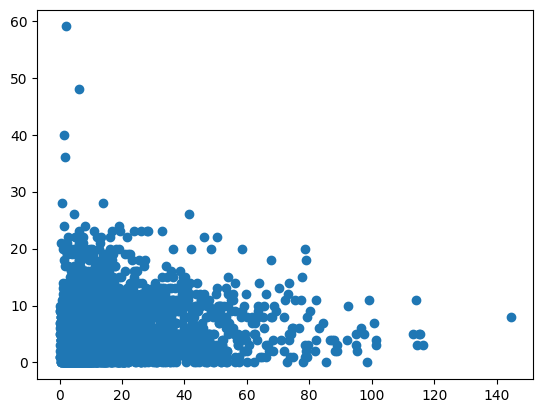

In [ ]:
# Now we just produse some other plots, looking at corrolations between diferent values.
x_value = 'FFT.258Hz'
y_value = 'atmos_enviro.AE_10.0'

print('Corrilation: {}'.format(df_flat[x_value].corr(df_flat[y_value])))

plt.scatter(x=df_flat[x_value], y=df_flat[y_value])
plt.show()

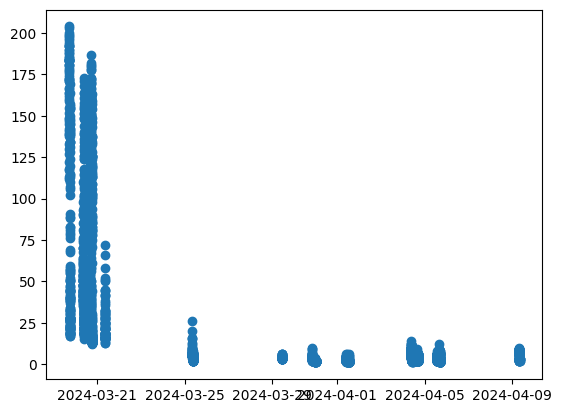

In [16]:
# simply plotting values against time.
plt.plot(df_flat['datetime'],df_flat['no2'],'o')
plt.show()

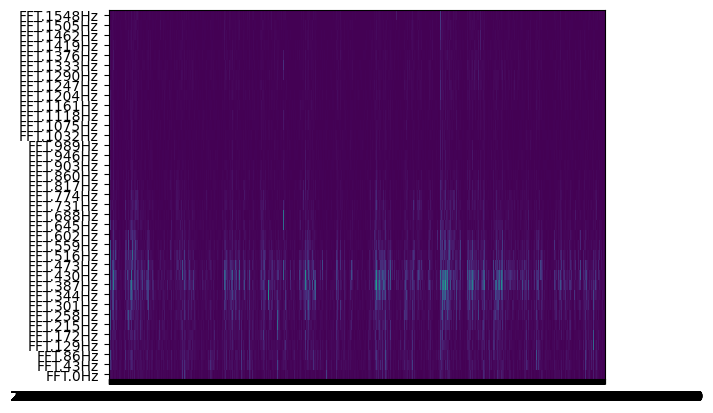

In [17]:
# produucing a spectrogram of the audio data.
bins = df_flat.filter(like='FFT').columns

plt.pcolor(df_flat.filter(like='FFT').T)
plt.yticks(np.arange(0.5, bins.size, 1), bins)
plt.xticks(np.arange(0.5, len(df_flat.index), 1), df_flat.datetime)
plt.show()

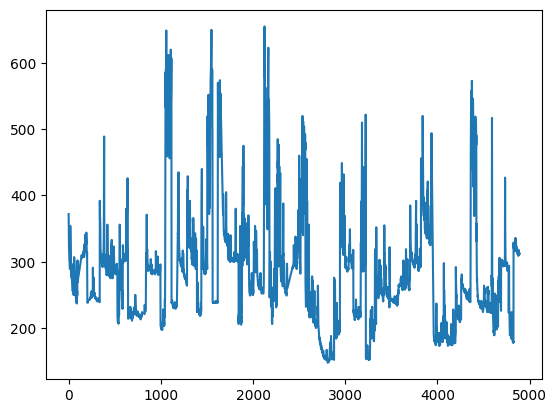

In [18]:
# plot against measurement reading rather than time. (no gaps)
plt.plot(df_flat.co)
plt.show()

In [19]:
# if we want to filter out some part of the data based on time, this is how we do it.

start_time = pytz.timezone('UTC').localize(datetime(2023, 10, 23, 10, 55))
end_time = datetime.now(pytz.timezone('UTC'))

mask = (df_flat['datetime'] > start_time) & (df_flat['datetime'] < end_time)

In [20]:
# we can then get only those rows that are within the time range we are looking for by dooing this:
df_flat[mask]

datetime   fix  speed       angle  satellites  \
0    2024-04-04 16:07:01+00:00  True   0.04    0.000000         5.0   
1    2024-04-04 16:07:06+00:00  True   0.42    0.000000         5.0   
2    2024-04-04 16:07:11+00:00  True   0.42    0.000000         8.0   
3    2024-04-04 16:07:16+00:00  True   6.62  268.350006         8.0   
4    2024-04-04 16:07:26+00:00  True  10.16    7.000000         7.0   
...                        ...   ...    ...         ...         ...   
4887 2024-03-25 08:45:40+00:00  True   0.72   24.040001         6.0   
4888 2024-03-25 08:45:45+00:00  True   0.72   24.040001         5.0   
4889 2024-03-25 08:45:50+00:00  True   0.38   36.169998         5.0   
4890 2024-03-25 08:45:55+00:00  True   0.38   36.169998         5.0   
4891 2024-03-25 08:46:00+00:00  True   0.43  125.769997         5.0   

      location.lat  location.long  location.alt  humidity  temp  heat_index  \
0      5127.496094     232.294098     65.300003      64.6  17.2       16.66   
1      5127.496094     232.294403     65.300003      65.2  17.0       16.46   
2      5127.496582     232.305405     65.300003      65.0  17.0       16.45   
3      5127.497070     232.322098     65.300003      64.6  16.9       16.33   
4      5127.511719     232.336197     65.099998      65.3  16.6       16.02   
...            ...            ...           ...       ...   ...         ...   
4887   5127.904785     233.282593     47.900002      70.8  10.0        8.90   
4888   5127.905273     233.282196     48.900002      70.7  10.0        8.90   
4889   5127.905273     233.281494     48.900002      70.9  10.0        8.91   
4890   5127.904297     233.279800     50.299999      70.8  10.0        8.90   
4891   5127.903320     233.278107     50.299999      70.8  10.0        8.90   

      no2  c2h5ch    voc     co  atmos_enviro.AE_1.0  atmos_enviro.AE_2.5  \
0     8.0   168.0  159.0  372.0                  0.0                  0.0   
1     7.0   162.0  152.0  355.0                  0.0                  1.0   
2     6.0   155.0  146.0  342.0                  0.0                  1.0   
3     6.0   149.0  141.0  334.0                  0.0                  1.0   
4     6.0   138.0  130.0  321.0                  0.0                  1.0   
...   ...     ...    ...    ...                  ...                  ...   
4887  4.0    47.0   41.0  312.0                  2.0                  5.0   
4888  4.0    47.0   41.0  312.0                  2.0                  4.0   
4889  4.0    47.0   41.0  311.0                  2.0                  4.0   
4890  3.0    47.0   41.0  311.0                  2.0                  4.0   
4891  4.0    47.0   40.0  312.0                  2.0                  5.0   

      atmos_enviro.AE_10.0  FFT.0Hz  FFT.43Hz  FFT.86Hz  FFT.129Hz  FFT.172Hz  \
0                      1.0     2.20      3.66      2.69       1.65       1.10   
1                      1.0     2.08      5.31      5.19       5.80       5.00   
2                      1.0     3.78      2.75      6.90       4.94       7.14   
3                      1.0     8.36      2.14     13.55      11.78       8.67   
4                      1.0     7.02      5.25      7.39       6.59       8.67   
...                    ...      ...       ...       ...        ...        ...   
4887                   6.0     5.68      8.54      4.94       4.58       3.72   
4888                   4.0     1.77      1.65      5.92       6.41       5.13   
4889                   5.0     0.92      3.54      6.65       5.31       2.01   
4890                   5.0     2.44      2.08      2.32       1.59       1.89   
4891                   6.0     2.99      2.69      2.38       1.77       2.69   

      FFT.215Hz  FFT.258Hz  FFT.301Hz  FFT.344Hz  FFT.387Hz  FFT.430Hz  \
0          2.14       0.67       0.12       0.85       0.37       1.34   
1          5.00       1.77      11.17       7.87       5.43      28.20   
2         10.56      17.64      11.60      23.01      29.17      24.35   
3          6.65      10.07

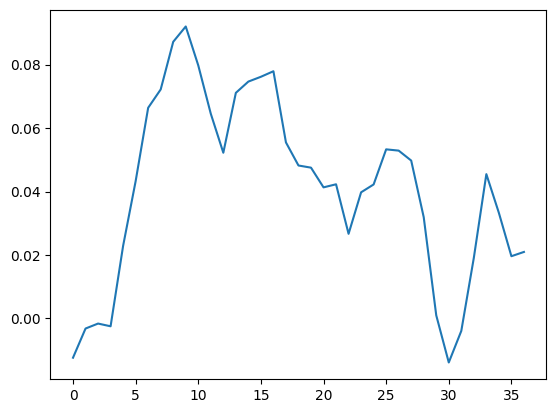

In [21]:
# foring through all the FFT bins to see if any of them corrolate well with other values.
freq=[]
corr=[]
for bin in bins:
    freq.append(bin)
    corr.append(df_flat[mask]['atmos_enviro.AE_10.0'].corr(df_flat[mask][bin]))

# results are saved to a list for that they can be plotted.
df_FFTCorrilation = pd.DataFrame({'Frequency':freq, 'Corrilation':corr})
df_FFTCorrilation

plt.plot(df_FFTCorrilation['Corrilation'])
plt.show()

Corrilation: 0.7317139401865612


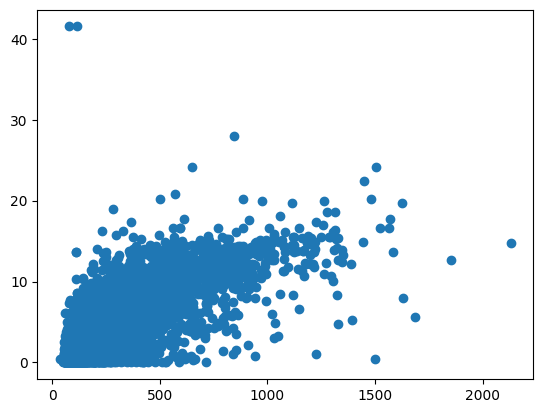

In [22]:
# more corralation stuff
print('Corrilation: {}'.format(df_flat.filter(like='FFT').sum(axis='columns').corr(df_flat[mask]['speed'])))

plt.scatter(df_flat[mask].filter(like='FFT').sum(axis='columns'), df_flat[mask]['speed'])
plt.show()